<a href="https://colab.research.google.com/github/FaisalT0435/Sistem-Deteksi-Hama-menggunakan-Deep-learning-dan-IoT/blob/main/KFold_MASK_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pycocotools
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import os

In [ ]:
os.chdir('/content/drive/MyDrive/Mask_RCNN/Dataset')

In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1Qkzrv5ICHEwHA89LN6xQS4alzi6bZysW/Mask_RCNN/Dataset


In [ ]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 4
NUM_EPOCHS = 1
NUM_WORKERS = 4
CHECKPOINT_FILE = "1152KaggleBest.pth.tar"
PIN_MEMORY = True
SAVE_MODEL = False
LOAD_MODEL = False
TRAIN_DIR = 'train'
VALID_DIR = 'valid'
TEST_DIR = 'test'
IMAGE_SIZE = [416,416]

In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [ ]:
import numpy as np

In [ ]:
class CCDataset(Dataset):
  def __init__(self, mode = 'train', augmentation=None):
    if mode == 'train':
      self.dataset_path = TRAIN_DIR
      ann_path = os.path.join(TRAIN_DIR, '_annotations.coco.json')
    if mode == 'valid':
      self.dataset_path = VALID_DIR
      ann_path = os.path.join(VALID_DIR, '_annotations.coco.json')
    if mode == 'test':
      self.dataset_path = TEST_DIR
      ann_path = os.path.join(TEST_DIR, '_annotations.coco.json')
    
    self.coco = COCO(ann_path)
    self.cat_ids = self.coco.getCatIds()
    self.augmentation=augmentation

  def __len__(self):
      return len(self.coco.imgs)
  
  def get_masks(self, index):
      ann_ids = self.coco.getAnnIds([index])
      anns = self.coco.loadAnns(ann_ids)
      masks=[]

      for ann in anns:
            mask = self.coco.annToMask(ann)
            masks.append(mask)

      return masks

  def get_boxes(self, masks):
      num_objs = len(masks)
      boxes = []

      for i in range(num_objs):
          x,y,w,h = cv2.boundingRect(masks[i])
          boxes.append([x, y, x+w, y+h])

      return np.array(boxes)

  def __getitem__(self, index):
      # Load image
      img_info = self.coco.loadImgs([index])[0]
      image = cv2.imread(os.path.join(self.dataset_path,
                                    img_info['file_name']))
      masks = self.get_masks(index)

      if self.augmentation:
        augmented = self.augmentation(image=image, masks=masks)
        image, masks = augmented['image'], augmented['masks']

      image = image.transpose(2,0,1) / 255.

      # Load masks
      masks = np.array(masks)
      boxes = self.get_boxes(masks)

      # Create target dict
      num_objs = len(masks)
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.ones((num_objs,), dtype=torch.int64)
      masks = torch.as_tensor(masks, dtype=torch.uint8)
      image = torch.as_tensor(image, dtype=torch.float32)
      data = {}
      data["boxes"] =  boxes
      data["labels"] = labels
      data["masks"] = masks

      return image, data

In [ ]:
def collate_fn(batch):
  images = list()
  targets = list()
  for b in batch:
        images.append(b[0])
        targets.append(b[1])
  images = torch.stack(images, dim=0)
  return images, targets

In [ ]:
import albumentations as A
import numpy as np # linear algebra


In [ ]:
import pandas as pd

In [ ]:
transform = A.Compose([
    A.Resize(600,600),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(
        contrast_limit=0.2, brightness_limit=0.3, p=0.5),
    A.OneOf([
        A.ImageCompression(p=0.8),
        A.RandomGamma(p=0.8),
        A.Blur(p=0.8),
        A.Equalize(mode='cv',p=0.8)
    ], p=1.0),
    A.OneOf([
        A.ImageCompression(p=0.8),
        A.RandomGamma(p=0.8),
        A.Blur(p=0.8),
        A.Equalize(mode='cv',p=0.8),
    ], p=1.0)
])

In [ ]:
import torch
from tqdm import tqdm
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import datasets, models

In [ ]:
# n_classes = 3
coco = COCO(os.path.join( "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


{0: {'id': 0, 'name': 'Pest', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Belalang', 'supercategory': 'Pest'},
 2: {'id': 2, 'name': 'Sehat', 'supercategory': 'Pest'},
 3: {'id': 3, 'name': 'Ulat', 'supercategory': 'Pest'},
 4: {'id': 4, 'name': 'Wereng', 'supercategory': 'Pest'}}

In [ ]:
def get_model():
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
            in_features, num_classes=n_classes)
    model.to(DEVICE)
    
    return model

In [ ]:
def save_checkpoint(state, filename="mask_rcnn.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    #optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
if LOAD_MODEL and CHECKPOINT_FILE in os.listdir():
        print("Loading checkpoint")
        load_checkpoint(torch.load(CHECKPOINT_FILE), model, optimizer, LEARNING_RATE)

In [ ]:
y = os.path.join( 'train')
y

'train'

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset


In [ ]:
def train_one_epoch(loader, model, optimizer, device):
    loop = tqdm(loader)

    all_losses = []
    all_losses_dict = []
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    for batch_idx, (images, targets) in  enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
          
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
          
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)


        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    
    return(np.mean(all_losses))
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    # print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
    #     epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
    #     all_losses_dict['loss_classifier'].mean(),
    #     all_losses_dict['loss_box_reg'].mean(),
    #     all_losses_dict['loss_rpn_box_reg'].mean(),
    #     all_losses_dict['loss_objectness'].mean()
    # ))

In [ ]:
best_vloss = np.inf
def validate(loader, model, optimizer, device, epoch):
    global best_vloss
    loop = tqdm(loader)
    running_vloss = 0
    for batch_idx, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
          loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        running_vloss += losses
        
    avg_vloss = running_vloss / (batch_idx + 1)
    
    print(f"Avg Valid Loss: {avg_vloss}")
    if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      if SAVE_MODEL:
            print("Model improved, saving...")
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=f"1152KaggleBest_second_{epoch}.pth.tar")
    print('\n')
    return avg_vloss

In [ ]:
from sklearn.model_selection import KFold

train_dataset = CCDataset(mode='train', augmentation=transform)
valid_dataset = CCDataset(mode='valid', augmentation=transform)
dataset = ConcatDataset([train_dataset, valid_dataset])
k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)
avg_train_loss = []
avg_val_loss = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print(f'FOLD {fold}')
  print('--------------------------------')
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  val_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = DataLoader(dataset=dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=4,
                                pin_memory=PIN_MEMORY,
                                collate_fn=collate_fn,
                                sampler=train_subsampler)


  valid_loader = DataLoader(dataset=dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                pin_memory=PIN_MEMORY,
                                collate_fn=collate_fn,
                                sampler=val_subsampler)
  model = get_model()
  optimizer = torch.optim.AdamW(params=model.parameters(),
                                  lr=LEARNING_RATE,
                                  weight_decay=WEIGHT_DECAY)
  
  model.train()
  train_error =[]
  val_error = []
  num_epochs = 25
  for epoch in range(num_epochs):
                  print(f"Epoch: {epoch}")
                  train = train_one_epoch(train_loader, model, optimizer, DEVICE)
                  vloss= validate(valid_loader, model, optimizer, DEVICE, epoch)
                  train_error.append(train)
                  val_error.append(vloss.tolist())
  avg_train_loss.append(sum(train_error) / len(train_error))
  avg_val_loss.append(sum(val_error) / len(val_error))
  print(avg_train_loss)
  print(avg_val_loss)

  # plt.subplot(2, 1, 2)
  # plt.plot(train_error, label='Training Loss')
  # plt.plot(val_error, label='Validation Loss')
  # plt.legend()
  # plt.title('Training Loss')
  # plt.axvline(num_epochs, color="gray", label="Epoch")
  # plt.ylabel('merror')
  # plt.ylabel('Loss')

  # plt.show()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
FOLD 0
--------------------------------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can

  0%|          | 0.00/170M [00:00<?, ?B/s]

Epoch: 0


100%|██████████| 15/15 [00:40<00:00,  2.67s/it]


Avg Valid Loss: 2.981703042984009


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Avg Valid Loss: 2.954174041748047


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 2.925604820251465


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.9148266315460205


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 2.8783440589904785


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.8198561668395996


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Avg Valid Loss: 2.8575918674468994


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.8309061527252197


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 2.8314456939697266


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.8000309467315674


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.8000121116638184


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 2.7396817207336426


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 2.733311891555786


Epoch: 13


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.7472805976867676


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.7318806648254395


Epoch: 15


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Avg Valid Loss: 2.6682846546173096


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.7029829025268555


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.598064422607422


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.6861088275909424


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.5720698833465576


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.6706817150115967


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.6311514377593994


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.6784253120422363


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 2.6179471015930176


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.5828161239624023


[2.711760519186656]
[2.7582073116302492]
FOLD 1
--------------------------------
Epoch: 0


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 3.255444049835205


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 3.2029263973236084


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 3.1884374618530273


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 3.2066311836242676


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 3.1763317584991455


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 3.1290979385375977


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 3.1039621829986572


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 3.0803191661834717


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 3.123413562774658


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 3.0457839965820312


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 3.004390001296997


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 3.002551317214966


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.9793643951416016


Epoch: 13


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.9545819759368896


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.9287471771240234


Epoch: 15


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.9742746353149414


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.960977792739868


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.9326558113098145


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Avg Valid Loss: 2.927389144897461


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Avg Valid Loss: 2.865523338317871


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.8598222732543945


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.852083206176758


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.8270466327667236


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.84842848777771


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.7964258193969727


[2.711760519186656, 2.996908400535584]
[2.7582073116302492, 3.0090643882751467]
FOLD 2
--------------------------------
Epoch: 0


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.790924549102783


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Avg Valid Loss: 2.7633705139160156


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Avg Valid Loss: 2.7622196674346924


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.7128617763519287


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.701369285583496


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.6731998920440674


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.693833112716675


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.677499532699585


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 2.6342508792877197


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.6281352043151855


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.584298849105835


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.5622222423553467


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 2.488386869430542


Epoch: 13


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.535388231277466


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.4629485607147217


Epoch: 15


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.445765256881714


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.457202672958374


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 2.454547643661499


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.4125332832336426


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 2.3995988368988037


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.3644120693206787


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Avg Valid Loss: 2.3595118522644043


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.389962911605835


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.3349554538726807


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.336958408355713


[2.711760519186656, 2.996908400535584, 2.5589494719505312]
[2.7582073116302492, 3.0090643882751467, 2.545054302215576]
FOLD 3
--------------------------------
Epoch: 0


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.7724199295043945


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Avg Valid Loss: 2.722177743911743


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.7221429347991943


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 2.654489755630493


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 2.731555938720703


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.66546368598938


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 2.655745506286621


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 2.6750149726867676


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 2.611567497253418


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.5415172576904297


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.5498995780944824


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.5520284175872803


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.519432544708252


Epoch: 13


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Avg Valid Loss: 2.5003442764282227


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 2.5006206035614014


Epoch: 15


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.467888832092285


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.416942834854126


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 2.4461615085601807


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 2.4082274436950684


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 2.375425100326538


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.3944144248962402


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.325835943222046


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.3362889289855957


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.2999541759490967


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.3261964321136475


[2.711760519186656, 2.996908400535584, 2.5589494719505312, 2.617152179956437]
[2.7582073116302492, 3.0090643882751467, 2.545054302215576, 2.5268702507019043]
FOLD 4
--------------------------------
Epoch: 0


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 3.0224249362945557


Epoch: 1


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Avg Valid Loss: 2.9095664024353027


Epoch: 2


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.965806245803833


Epoch: 3


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 2.908895254135132


Epoch: 4


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Avg Valid Loss: 2.942103624343872


Epoch: 5


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 2.847378730773926


Epoch: 6


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 2.8068106174468994


Epoch: 7


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 2.8860576152801514


Epoch: 8


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Avg Valid Loss: 2.827009439468384


Epoch: 9


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 2.7769694328308105


Epoch: 10


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 2.8305513858795166


Epoch: 11


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.795954704284668


Epoch: 12


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 2.7022993564605713


Epoch: 13


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Avg Valid Loss: 2.716538906097412


Epoch: 14


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.665325164794922


Epoch: 15


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 2.7198925018310547


Epoch: 16


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 2.6976253986358643


Epoch: 17


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 2.6590826511383057


Epoch: 18


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Avg Valid Loss: 2.6690001487731934


Epoch: 19


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Avg Valid Loss: 2.676628351211548


Epoch: 20


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Avg Valid Loss: 2.62587833404541


Epoch: 21


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Avg Valid Loss: 2.6093151569366455


Epoch: 22


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Avg Valid Loss: 2.61708927154541


Epoch: 23


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Avg Valid Loss: 2.5253632068634033


Epoch: 24


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

Avg Valid Loss: 2.59712553024292


[2.711760519186656, 2.996908400535584, 2.5589494719505312, 2.617152179956437, 2.73638552125295]
[2.7582073116302492, 3.0090643882751467, 2.545054302215576, 2.5268702507019043, 2.7600276947021483]


In [ ]:
avg_train_loss

[2.711760519186656,
 2.996908400535584,
 2.5589494719505312,
 2.617152179956437,
 2.73638552125295]

In [ ]:
avg_val_loss

[2.7582073116302492,
 3.0090643882751467,
 2.545054302215576,
 2.5268702507019043,
 2.7600276947021483]

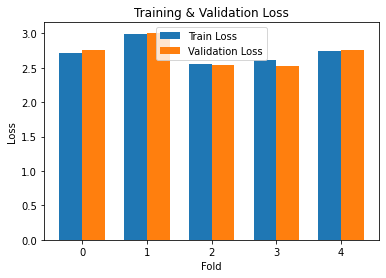

In [ ]:
index = np.arange(5)
x_label = [0,1,2,3,4]
bar_width = 0.35

fig, ax = plt.subplots()
train = ax.bar(index, avg_train_loss, bar_width,
                label="Train Loss")

valid = ax.bar(index+bar_width, avg_val_loss,
                 bar_width, label="Validation Loss")

ax.set_xlabel('Fold')
ax.set_ylabel('Loss')
ax.set_title('Training & Validation Loss')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_label)

# ax.set_xticklabels(["ASB", "Violence", "Theft", "Public Order", "Drugs"])
ax.legend()

plt.show()

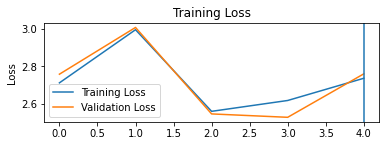

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.legend()
plt.title('Training Loss')
plt.axvline(4,  label="Epoch")
# plt.ylabel('merror')
plt.ylabel('Loss')

plt.show()

In [ ]:
from torchvision.utils import draw_bounding_boxes

In [ ]:
import cv2

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Pest', 'Belalang', 'Sehat', 'Ulat', 'Wereng']

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Mask_RCNN/Dataset/test/_classes.csv', sep=',')

labels

,filename,Belalang,Sehat,Ulat,Wereng
0,Padi-13-_jpg.rf.4347bdf6715822ee18de86f99baa2b...,0,1,0,0
1,Padi-76-_jpg.rf.41feb984d4cfdd0fb5ae81163bbe00...,0,1,0,0
2,Ulat-9-_jpg.rf.20c45bf0373f458c1692b40ac0ed35b...,0,0,1,0
3,Padi-24-_jpg.rf.0f5f28a35e76b2029a8cff485ad3b7...,0,1,0,0
4,Wereng-34-_jpg.rf.31ea5a15a860e5f56de4b5e66132...,0,0,0,1
...,...,...,...,...,...
136,Ulat-53-_jpg.rf.faf2863f32a9284c6ad08d77a78fb5...,0,0,1,0
137,Ulat-63-_jpg.rf.82e1d185080e96dfe453f1ff44a1a7...,0,0,1,0
138,Ulat-57-_jpg.rf.b9b2e47a21036fc0d0968ff393de5c...,0,0,1,0
139,Padi-11-_jpg.rf.7b49356277f8eb26bd7b92361d36a6...,0,1,0,0


In [ ]:
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

In [ ]:
test_labels = labels.apply(get_label, axis=1)

test_labels.to_numpy()

len(test_labels)


141

In [ ]:
prediksi = []
for i in range(len(test_labels)):
  if (test_labels[i] == ' Wereng' or test_labels[i] == ' Belalang' or test_labels[i] == ' Ulat'):
    prediksi.append('Pest')
  else :
    prediksi.append("Healty")

prediksi

['Healty',
 'Healty',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Healty',
 'Healty',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Healty',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'Pest',
 'Pest',
 'Healty',
 'Pest',
 'Pest',
 'P

In [ ]:
def predict_single_frame(frame):
    images = cv2.resize(frame, IMAGE_SIZE, cv2.INTER_LINEAR)/255
    images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
    images = images.swapaxes(1, 3).swapaxes(2, 3)
    images = list(image.to(DEVICE) for image in images)
    
    with torch.no_grad():
      pred = model(images)
    
    # print(pred)
    
    im = images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.float32)
    im2 = np.zeros_like(im).astype(np.float32)
    for i in range(len(pred[0]['masks'])):
        msk=pred[0]['masks'][i,0].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        box=pred[0]['boxes'][i].detach().cpu().numpy()
        lbl=pred[0]['labels'][i].detach().cpu().numpy()
        
        if (lbl == 1):
          x = "Pest"
        elif  (lbl == 2):
          x = "Healty"
        elif  (lbl == 3):
          x = "Pest"
        elif  (lbl == 4):
          x = "Pest"
        # print(x)
        if scr>0.4 :
            cv2.rectangle(im, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,1), 2)
            cv2.putText(im, "{0:.2f}%".format(scr*100), (int(box[0]+10), int(box[1])+40), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,0,1), 2, cv2.LINE_AA)
            cv2.putText(im, x , (int(box[0]+4), int(box[1])+15), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,0,1), 2, cv2.LINE_AA)
            im2[:,:,0][msk>0.87] = np.random.uniform(0,1)
            im2[:, :, 1][msk > 0.87] = np.random.uniform(0,1)
            im2[:, :, 2][msk > 0.87] = np.random.uniform(0,1)
            

    return (cv2.addWeighted(im, 0.8, im2, 0.2,0)*255).astype(np.uint8), x

In [ ]:
import os
from os import listdir

hasil_pred = []
 
# get the path/directory
folder_dir = "/content/drive/MyDrive/Mask_RCNN/Dataset/test/"
# x = os.listdir(folder_dir)
# x

for images in os.listdir(folder_dir):
 
    # check if the image ends with png
    if (images.endswith(".jpg")):
        # print(images)
      cap = cv2.VideoCapture(folder_dir+images)
      model.train(False)

      if (cap.isOpened()== False): 
          print("Error opening video stream or file")

      images = []   
      while(cap.isOpened()):
          ret, frame = cap.read()
          if ret == True:
              result_frame, predict = predict_single_frame(frame)
              images.append(result_frame)
              hasil_pred.append (predict)
          else: 
              break

      cap.release()

In [ ]:
# import os
# from os import listdir

# hasil_pred = []
 
# # get the path/directory
# folder_dir = "/content/drive/MyDrive/Ta/Mask_RCNN/Dataset/test/"
# for images in os.listdir(folder_dir):
 
#     # check if the image ends with png
#     if (images.endswith(".jpg")):
#         # print(images)
#       cap = cv2.VideoCapture(folder_dir+images)
#       model.train(False)

#       if (cap.isOpened()== False): 
#           print("Error opening video stream or file")

#       images = []   
#       while(cap.isOpened()):
#           ret, frame = cap.read()
#           if ret == True:
#               result_frame, predict = predict_single_frame(frame)
#               images.append(result_frame)
#               hasil_pred.append (predict)
#           else: 
#               break

#       cap.release()

In [ ]:
df_hasil_pred = pd.DataFrame(hasil_pred)
df_hasil_pred [1] = pd.DataFrame(prediksi)

df_hasil_pred

,0,1
0,Healty,Healty
1,Healty,Healty
2,Pest,Pest
3,Healty,Healty
4,Pest,Pest
...,...,...
136,Pest,Pest
137,Pest,Pest
138,Pest,Pest
139,Healty,Healty


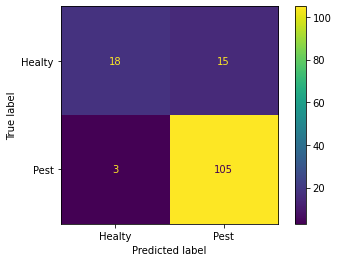

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = df_hasil_pred[0]
predicted = df_hasil_pred[1]

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Healty', 'Pest'])

cm_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, predicted, target_names=['Healty', 'Pest']))

              precision    recall  f1-score   support

      Healty       0.86      0.55      0.67        33
        Pest       0.88      0.97      0.92       108

    accuracy                           0.87       141
   macro avg       0.87      0.76      0.79       141
weighted avg       0.87      0.87      0.86       141



In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Mask_RCNN/Dataset/Uji/2023-01-22_12.17.14.272.png')
model.train(False)

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

images = []   
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        result_frame, label = predict_single_frame(frame)
        images.append(result_frame)
    else: 
        break

cap.release()

In [ ]:
label

'Pest'

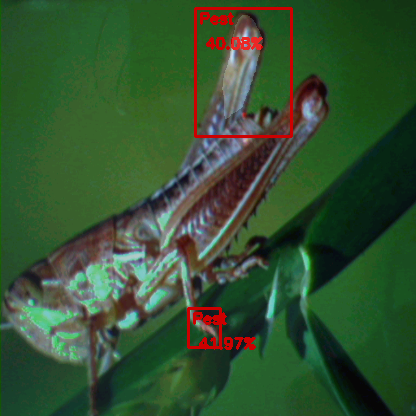

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(result_frame)

In [ ]:
!pip install paho-mqtt
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for paho-mqtt: filename=paho_mqtt-1.6.1-py3-none-any.whl size=62132 sha256=bf8bd21e75c68779898b585bc5545bbb053e8af69b1c9f55fed6bc4e3a845088
  Stored in directory: /root/.cache/pip/wheels/6a/48/01/c895c027e9b9367ec5470fbf371ee56e795a49ac6a19aa4c9f
Successfully built paho-mqtt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import time

from paho.mqtt import client as mqtt_client

broker = 'broker.emqx.io'
port = 1883
topic1 = "detect/Pest"
# topic0 = "detect/healthy"
# generate client ID with pub prefix randomly
client_id = f'python-mqtt-{random.randint(0, 1000)}'
username = 'emqx'
password = 'public'

def connect_mqtt():
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print("Failed to connect, return code %d\n", rc)

    client = mqtt_client.Client(client_id)
    client.username_pw_set(username, password)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client


def publish(client):
    
    msg_count = 0
    msg = ''
    while True:
        time.sleep(1)
        # pred = predict()
        # print (pred)
        deteksi = []
        for i in predicted:
            if (i == 'Pest')  :
                j = 'Pest'
                deteksi.append(j)
            else:
                j = 'healthy'
                deteksi.append(j)
        # print (deteksi)
    
        for x in deteksi:
            if (x == 'Pest'):
                msg = "Pest"
                result = client.publish(topic1, msg)
                status = result[0]
                if status == 0:
                    print(f"Send `{msg}` to topic `{topic1}`")
                else:
                    print(f"Failed to send message to topic {topic1}")


def run():
    client = connect_mqtt()
    client.loop_start()
    publish(client)


In [ ]:
run()

Streaming output truncated to the last 5000 lines.
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send `Pest` to topic `detect/Pest`
Send

KeyboardInterrupt: ignored

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Mask_RCNN/Dataset/Uji/2023-01-22_11.55.18.642.png')
model.train(False)

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

images = []   
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        result_frame, pred = predict_single_frame(frame)
        images.append(result_frame)
    else: 
        break

cap.release()

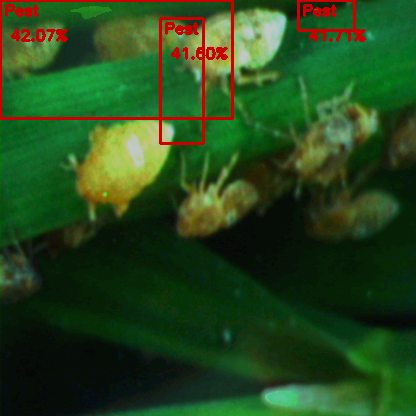

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(result_frame)